In [53]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
from torch.utils.tensorboard import SummaryWriter
from torchinfo import summary

In [54]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

continue_train = False

os.makedirs('results', exist_ok=True)
model_path = 'results/model.pth'
optimizer_path = 'results/optimizer.pth'
dataset_path = '../datasets/'

n_epochs = 10
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.001
momentum = 0.9
log_interval = 200

writer = SummaryWriter('logs')

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [55]:
transform = torchvision.transforms.Compose([ 
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(
                    (0.1307,),(0.3081,))
                ])

train_dataset = torchvision.datasets.EMNIST(
                    dataset_path,
                    split = 'balanced',
                    train = True,
                    download = True,
                    transform = transform)

test_dataset = torchvision.datasets.EMNIST(
                    dataset_path,
                    split = 'balanced',
                    train = False,
                    download = True,
                    transform = transform)

train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size = batch_size_train,
        shuffle = True,
        num_workers=4,
        pin_memory=True)
 
test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size = batch_size_test,
        shuffle = True,
        num_workers = 4,
        pin_memory = True)

In [56]:
label_converter = {
    0: chr(48),
    1: chr(49),
    2: chr(50),
    3: chr(51),
    4: chr(52),
    5: chr(53),
    6: chr(54),
    7: chr(55),
    8: chr(56),
    9: chr(57),
    10: chr(65),
    11: chr(66),
    12: chr(67),
    13: chr(68),
    14: chr(69),
    15: chr(70),
    16: chr(71),
    17: chr(72),
    18: chr(73),
    19: chr(74),
    20: chr(75),
    21: chr(76),
    22: chr(77),
    23: chr(78),
    24: chr(79),
    25: chr(80),
    26: chr(81),
    27: chr(82),
    28: chr(83),
    29: chr(84),
    30: chr(85),
    31: chr(86),
    32: chr(87),
    33: chr(88),
    34: chr(89),
    35: chr(90),
    36: chr(97),
    37: chr(98),
    38: chr(100),
    39: chr(101),
    40: chr(102),
    41: chr(103),
    42: chr(104),
    43: chr(110),
    44: chr(113),
    45: chr(114),
    46: chr(116),
}

In [57]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


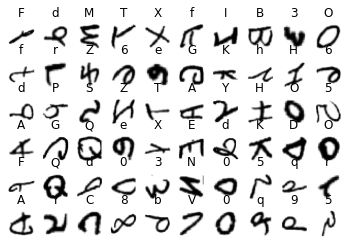

In [58]:
figure = plt.figure()
num_of_images = 60
for i in range(1, 61):
    plt.subplot(6, 10, i)
    plt.axis('off')
    plt.imshow(images[i].numpy().squeeze(), cmap='gray_r')
    plt.title(label_converter[labels[i].item()])

In [59]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.input_size = 1
        self.hidden_sizes = [100,500,500]
        self.output_size = 47
        
        self.conv1 = nn.Conv2d(self.input_size, self.hidden_sizes[0], kernel_size=5)
        self.conv2 = nn.Conv2d(self.hidden_sizes[0], self.hidden_sizes[1], kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(self.hidden_sizes[1]*2*2, self.hidden_sizes[2])
        self.fc2 = nn.Linear(self.hidden_sizes[2], self.output_size)

    def forward(self, x):
        # x = (batch_size, neurons, height, width)
        #print('0:', x.size()) # x = (64, 1, 28, 28)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        
        #print('1:', x.size())  # x = (64, 20, 12, 12)
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 3))
        
        #print('2:', x.size()) # x = (64, 50, 2, 2)
        x = x.view(x.size(0), -1)
        
        #print('3:', x.size()) # x = (64, 200)
        x = F.relu(self.fc1(x))
        
        #print('4:', x.size()) # x = (64, 100)
        x = F.dropout(x, training=self.training)
        
        #print('5:', x.size()) # x = (64, 100)
        x = self.fc2(x)
        
        #print('6:', x.size()) # x = (64, 47)
        return x

In [60]:
network = Net()
network.to(device)
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

if continue_train:
    network_state_dict = torch.load(model_path)
    network.load_state_dict(network_state_dict)

    optimizer_state_dict = torch.load(optimizer_path)
    optimizer.load_state_dict(optimizer_state_dict)

In [61]:
summary(network, (batch_size_train, network.input_size, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      --                        --
├─Conv2d: 1-1                            [64, 100, 24, 24]         2,600
├─Conv2d: 1-2                            [64, 500, 8, 8]           1,250,500
├─Dropout2d: 1-3                         [64, 500, 8, 8]           --
├─Linear: 1-4                            [64, 500]                 1,000,500
├─Linear: 1-5                            [64, 47]                  23,547
Total params: 2,277,147
Trainable params: 2,277,147
Non-trainable params: 0
Total mult-adds (G): 5.28
Input size (MB): 0.20
Forward/backward pass size (MB): 46.16
Params size (MB): 9.11
Estimated Total Size (MB): 55.46

In [62]:
def train(epoch):
    network.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        preds = network(images)
        # calculate loss
        loss = F.cross_entropy(preds, labels)
        
        # backward pass
        loss.backward()
        optimizer.step()
        
        if i % log_interval == 0:
            step = (i + 1) * epoch + (epoch-1) * len(train_loader)
            progress_pct = round(100. * i / len(train_loader))
            
            writer.add_scalar('Loss/train', loss.item(), step)
            print(f'Train Epoch: {epoch} ({progress_pct}%)\tLoss: {round(loss.item(), 4)}')

    torch.save(network.state_dict(), model_path)
    torch.save(optimizer.state_dict(), optimizer_path)
    return preds

In [63]:
def test(epoch):
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)
            
            preds = network(images)
            
            test_loss += F.cross_entropy(preds, labels, reduction='sum').item()
            
            pred = preds.data.max(1, keepdim=True)[1]
            
            correct += pred.eq(labels.data.view_as(pred)).sum()
    
            if i % log_interval == 0:
                step = (i+1) * epoch + (epoch-1) *len(test_loader)
                writer.add_scalar('Loss/test', test_loss / len(test_loader.dataset), step)
                
    test_loss /= len(test_loader.dataset)
        
    test_accuracy = 100. * correct / len(test_loader.dataset)
    test_accuracy = int(test_accuracy)
    writer.add_scalar('Accuracy/test', test_accuracy, epoch)
    print(f'\nTest set: Avg. loss: {round(test_loss, 4)}, Accuracy: {correct}/{len(test_loader.dataset)} ({round(test_accuracy)}%)\n')

In [64]:
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test(epoch)

Train Epoch: 1 (0%)	Loss: 3.9318
Train Epoch: 1 (11%)	Loss: 3.4521
Train Epoch: 1 (23%)	Loss: 2.5735
Train Epoch: 1 (34%)	Loss: 1.8719
Train Epoch: 1 (45%)	Loss: 1.8128
Train Epoch: 1 (57%)	Loss: 1.4639
Train Epoch: 1 (68%)	Loss: 1.1512
Train Epoch: 1 (79%)	Loss: 1.1513
Train Epoch: 1 (91%)	Loss: 1.1299

Test set: Avg. loss: 0.7965, Accuracy: 14182/18800 (75%)

Train Epoch: 2 (0%)	Loss: 1.0892
Train Epoch: 2 (11%)	Loss: 0.8998
Train Epoch: 2 (23%)	Loss: 0.9245
Train Epoch: 2 (34%)	Loss: 1.1784
Train Epoch: 2 (45%)	Loss: 0.9815
Train Epoch: 2 (57%)	Loss: 0.7347
Train Epoch: 2 (68%)	Loss: 0.739
Train Epoch: 2 (79%)	Loss: 0.8052
Train Epoch: 2 (91%)	Loss: 0.7477

Test set: Avg. loss: 0.5981, Accuracy: 15135/18800 (80%)

Train Epoch: 3 (0%)	Loss: 0.6873
Train Epoch: 3 (11%)	Loss: 0.6065
Train Epoch: 3 (23%)	Loss: 0.7583
Train Epoch: 3 (34%)	Loss: 0.7093
Train Epoch: 3 (45%)	Loss: 0.4894
Train Epoch: 3 (57%)	Loss: 0.5687
Train Epoch: 3 (68%)	Loss: 0.7617
Train Epoch: 3 (79%)	Loss: 0.5926
Tr

In [65]:
writer.add_graph(network, images.to(device))